In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this tutorial, we will show how to use deep learning to classify DNA sequences of Human, chimp, dogs! 
Using CNN with sequences is not easy and not classic but in Classification cases CNN still the most perfermant and recommanded that's why i will discover using CNN in Ginomics sequences simple classification which can be used later in more important cases in Ginomics field
First we gonna implement a CNN model for simple dna sequences data in binary classification problem.



In [2]:
import numpy as np
import pandas as pd
%matplotlib inline 
import cv2
from PIL import Image
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import tensorflow as tf



We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL ='https://raw.githubusercontent.com/zeyneb-chiha/DNA-Sequences-classification-using-CNN/main/DNAsequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


The next step is to organize the data into a format that can be passed into a CNN  algorithm: we use one-hot encoding


In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
LABELS_URL = 'https://raw.githubusercontent.com/zeyneb-chiha/DNA-Sequences-classification-using-CNN/main/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [17]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

In [18]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 39, 32)            1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4624      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
_________________________________________________________________


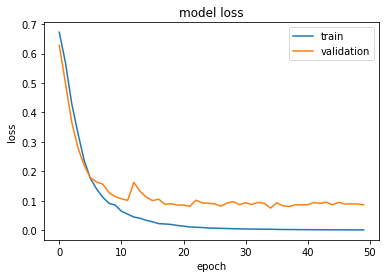

In [19]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

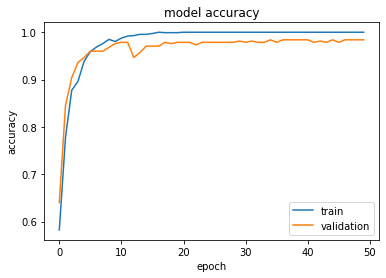

In [20]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[258   1]
 [  1 240]]


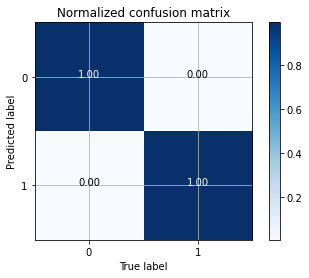

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

**Human, Chim and dog DNA seq classification**

In this case we have data of DNA sequence with different length which will cause trouble with one hot encoding algorithm , so here the part of data pre-processing is so important! Let's Start

In [22]:
human = pd.read_table('/content/drive/My Drive/dnadata/human_data.txt')
human.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


Let's check length of each sequence here!

In [23]:
human['seq_len'] = human.apply(lambda x: len(x['sequence']),axis=1)


In [25]:
human.head()

,sequence,class,seq_len
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,207
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,681
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1206
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437


Limitation of sequence length !

In [26]:
max_seq_length=50
human['sequence']=human.apply(lambda x:''.join(list(x['sequence'])[0:max_seq_length]),axis=1)


In [30]:
print( list(np.where(human["seq_len"]<50)[0]))
dropit=list(np.where(human["seq_len"]<50)[0])
print(len(dropit))


[49, 376, 457, 533, 731, 849, 850, 857, 1118, 1188, 1844, 1845, 1934, 2441, 2934, 2948, 3487, 3498, 3534, 3845, 3883, 3986, 4108, 4109, 4335]
25


In [31]:
human['sequence'].drop(index=[49,376,457,533,731,849,850,875,1118,1188, 1844, 1845, 1934, 2441, 2934, 2948, 3487, 3498, 3534, 3845, 3883, 3986, 4108, 4109, 4335],axis=1)

0       ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...
1       ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...
2       ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...
3       ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...
4       ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...
                              ...                        
4375    ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...
4376    ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...
4377    ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...
4378    ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...
4379    ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...
Name: sequence, Length: 4355, dtype: object

In [46]:
human['seq_len'] = human.apply(lambda x: len(x['sequence']),axis=1)
human.head(200)


,sequence,class,seq_len
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,50
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,50
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,50
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,50
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,50
...,...,...,...
195,NNGCTGGTGGAGGACACCTTCACCATAGATGAAGTCTCTGAAGTCC...,6,50
196,ATGCGTTTTGCTCGTTCAAAGAGAGGCTTGAGACTCAAAACTGTAG...,6,50
197,ATGCGTTTTGCTCGTTCAAAGAGAGGCTTGAGACTCAAAACTGTAG...,6,50
198,ATGAGGAACCAAGACCCAGGGAAGATGGGAAGGCAGAGAAAATCCA...,6,50


In [35]:
def write_to_txt(file_name,column):
    with open(file_name, 'w') as f:
        for item in column:
            f.write("%s\n" % item)

In [38]:
write_to_txt("/content/drive/MyDrive/dnadata/final seq",human.sequence)


In [39]:
df = pd.read_table('/content/drive/MyDrive/dnadata/final seq',sep=" ", names=['sequence'])
df.head()

,sequence
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...


In [40]:
df['seq_len'] =df.apply(lambda x: len(x['sequence']),axis=1)


In [41]:
df.head()

,sequence,seq_len
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,50
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,50
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,50
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,50
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,50


In [47]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in human:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())



In [43]:
print(type(input_features))
print(type(one_hot_encoded))

<class 'list'>
<class 'scipy.sparse.csr.csr_matrix'>


In [48]:
np.set_printoptions(threshold=40)
try:
  input_features = np.stack(input_features)
except ValueError:
        [print(one_hot_encoded.shape) for one_hot_encoded in input_features]

print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequence[0][:10],'...',sequence[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

(8, 6)
(5, 4)
(7, 6)
Example sequence
-----------------------
DNA Sequence #1:
 s ... s
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [49]:
labels =human.iloc[:,2].values                       


In [50]:

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[50 50 50 ... 50 50 50]]
One-hot encoded labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]]


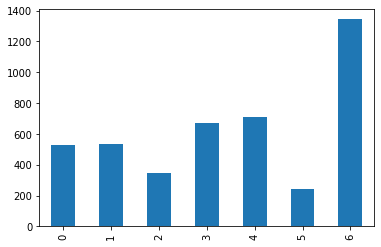

In [51]:
human['class'].value_counts().sort_index().plot.bar()


Apply same preprocessing for Dog DNA sequences

In [54]:
Dog = pd.read_table('/content/drive/MyDrive/dnadata/dog_data.txt')
Dog.head()
Dog['seq_len'] = human.apply(lambda x: len(x['sequence']),axis=1)
Dog.head()

,sequence,class,seq_len
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4,204
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4,681
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6,1044
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6,1044
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0,966
